In [1]:
import tensorflow as tf
from tf_slim import layers as slim
import numpy as np
import pandas as pd
import os
import librosa



In [2]:

def chunk(incoming, n_chunk):
    input_length = incoming.shape[1]
    chunk_length = input_length // n_chunk
    outputs = []
    for i in range(incoming.shape[0]):
        for j in range(n_chunk):
            outputs.append(incoming[i, j*chunk_length:(j+1)*chunk_length, :])
    outputs = np.array(outputs)
    return outputs


In [3]:

def audio_read(f):
    y, sr = librosa.core.load(f, sr=22050)
    d = librosa.core.get_duration(y=y, sr=sr)
    

    if d < 30:
        return None,None,None
    
    S = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=2048, hop_length=512, n_mels=128)
    S = np.transpose(np.log(1 + 10000 * S))
    S = np.expand_dims(S, axis=0)
    
    return y, S, int(d)


In [4]:
def positional_encoding(batch_size, n_pos, d_pos):
    # keep dim 0 for padding token position encoding zero vector
    position_enc = np.array([
        [pos / np.power(10000, 2 * (j // 2) / d_pos) for j in range(d_pos)]
        if pos != 0 else np.zeros(d_pos) for pos in range(n_pos)])

    position_enc[1:, 0::2] = np.sin(position_enc[1:, 0::2]) # dim 2i
    position_enc[1:, 1::2] = np.cos(position_enc[1:, 1::2]) # dim 2i+1
    position_enc = np.tile(position_enc, [batch_size, 1, 1])
    return position_enc

In [7]:
tf.compat.v1.disable_eager_execution()
class MusicHighlighter(object):
    def __init__(self):
        self.dim_feature = 64
        self.is_training = tf.compat.v1.placeholder_with_default(True, shape=(), name='is_training')
        self.bn_params = {'is_training': self.is_training, 'center': True, 'scale': True, 'updates_collections': None}

        # Placeholders for input data
        self.x = tf.compat.v1.placeholder(tf.float32, shape=[None, None, 128], name='x')
        self.pos_enc = tf.compat.v1.placeholder(tf.float32, shape=[None, None, self.dim_feature * 4], name='pos_enc')
        self.num_chunk = tf.compat.v1.placeholder(tf.int32, name='num_chunk')
        self.y = tf.compat.v1.placeholder(tf.float32, shape=[None, 9], name='y') 
        # Build the model
        self.build_model()

    def conv(self, inputs, filters, kernel, stride):
        dim = inputs.get_shape().as_list()[-2]
        return slim.conv2d(inputs, filters, [kernel, dim], [stride, dim],
                           activation_fn=tf.nn.relu,
                           normalizer_fn=slim.batch_norm,
                           normalizer_params=self.bn_params)

    def fc(self, inputs, num_units,dropout=0, act=tf.nn.relu):
        net = slim.fully_connected(inputs, num_units,
                                activation_fn=act,
                                normalizer_fn=slim.batch_norm,
                                normalizer_params=self.bn_params)

        net = tf.nn.dropout(net, rate=dropout)
        return net


    def attention(self, inputs, dim):
        outputs = self.fc(inputs, dim,0, act=tf.nn.tanh)
        outputs = self.fc(outputs, 1,0, act=None)
        attn_score = tf.nn.softmax(outputs, axis=1)
        return attn_score

    def build_model(self):
        # 2D Conv. feature extraction
        net = tf.expand_dims(self.x, axis=3)
        net = self.conv(net, self.dim_feature, 3, 2)
        net = self.conv(net, self.dim_feature * 2, 4, 2)
        net = self.conv(net, self.dim_feature * 4, 4, 2)

        # Global max-pooling
        net = tf.squeeze(tf.reduce_max(net, axis=1), axis=1)

        # Restore shape [batch_size, num_chunk, dim_feature]
        net = tf.reshape(net, [1, self.num_chunk, self.dim_feature * 4])

        # Attention mechanism
        attn_net = net + self.pos_enc
        attn_net = self.fc(attn_net, self.dim_feature * 4,0)
        attn_net = self.fc(attn_net, self.dim_feature * 4,0)
        self.attn_score = self.attention(attn_net, self.dim_feature * 4)

        net = self.fc(net, 512,dropout=0.0)
        chunk_predictions = self.fc(net, 9,dropout=0.0, act=tf.nn.sigmoid)
        self.overall_predictions = (tf.squeeze(tf.matmul(self.attn_score, chunk_predictions, transpose_a=True), axis=1))
        # self.overall_predictions = tf.nn.softmax(self.overall_predictions)
        epsilon = 1e-8
        # self.loss = tf.reduce_mean(tf.keras.losses.categorical_crossentropy(self.y, self.overall_predictions))
        # self.loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=self.y, logits=self.overall_predictions))
        # self.loss = tf.reduce_mean(-tf.reduce_sum(self.y * tf.math.log(self.overall_predictions), axis=1))
        self.loss = tf.keras.losses.BinaryCrossentropy()(self.y, self.overall_predictions)
        # Tính độ chính xác
        self.accuracy = self.calculate_accuracy(self.overall_predictions, self.y)
        self.saver = tf.compat.v1.train.Saver(tf.compat.v1.global_variables())

    def calculate(self, sess, x, pos_enc, num_chunk):
        feed_dict = {self.x: x, self.pos_enc: pos_enc, self.num_chunk: num_chunk, self.is_training: False}
        return sess.run(self.attn_score, feed_dict=feed_dict)

    # def calculate_accuracy(self, predictions, labels):
        
    #     predict = tf.nn.softmax(predictions)
    #     predicted_labels = tf.argmax(predict, axis=1)

    #     correct_predictions = tf.equal(predicted_labels, tf.argmax(labels, axis=1))  
        
    #     accuracy = tf.reduce_mean(tf.cast(correct_predictions, tf.float32))
        
    #     return accuracy

    # def calculate_accuracy(self, predictions, labels):
    #     # Chuyển predictions thành một one-hot vector
    #     max_indices = tf.argmax(predictions, axis=1)  # Lấy chỉ số của giá trị lớn nhất
    #     predicted_one_hot = tf.one_hot(max_indices, depth=labels.shape[1])  # Chuyển thành one-hot vector
        
    #     # So sánh với nhãn gốc
    #     correct_predictions = tf.reduce_all(tf.equal(predicted_one_hot, labels), axis=1)  
        
    #     # Tính accuracy
    #     accuracy = tf.reduce_mean(tf.cast(correct_predictions, tf.float32))
        
    #     return accuracy

    def calculate_accuracy(self, predictions, labels):

        predicted_labels = tf.cast(predictions > 0.5, tf.float32)

        correct_predictions = tf.equal(predicted_labels, labels)

        accuracy = tf.reduce_mean(tf.cast(correct_predictions, tf.float32))

        return accuracy
    def count_parameters(self):
        total_parameters = 0
        for variable in tf.compat.v1.trainable_variables():
            shape = variable.get_shape()
            variable_parameters = 1
            for dim in shape:
                variable_parameters *= dim  # Không cần gọi dim.value
            total_parameters += variable_parameters
        print("Total trainable parameters:", total_parameters)




In [ ]:

with tf.compat.v1.Session() as sess:
    model = MusicHighlighter()
    sess.run(tf.compat.v1.global_variables_initializer())
    model.count_parameters()




Total trainable parameters: 1048872


In [ ]:
num_epochs = 30
batch_size = 1
learning_rate = 0.001

# # Load song paths and labels
# with open("song_paths.txt", "r") as f:
#     song_paths = [line.strip() for line in f.readlines()]

# labels = pd.read_csv("filtered_annotations.csv").values  
base_directory = 'E:/Highlight detect/Jupyter'
data_df = pd.read_csv('new_labels.csv')
song_paths = data_df['audio_path'].values
labels = data_df.iloc[:, 2:].values
relative_paths = [os.path.relpath(path, base_directory) for path in song_paths]



# # In ra kết quả
# print(relative_paths[0])  
# Model setup
model = MusicHighlighter()
optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate).minimize(model.loss)

print(model.y.shape)
print(model.x.shape)

e:\Highlight detect\Jupyter\venv\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1697: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


(None, 9)
(None, None, 128)


In [39]:
# config = tf.compat.v1.ConfigProto()
# config.gpu_options.allow_growth = True
loss_per_epoch = [] 
accuracy_per_epoch = [] 

# Training loop
with tf.compat.v1.Session() as sess:
    sess.run(tf.compat.v1.global_variables_initializer())
    print("GPU available:", tf.test.gpu_device_name())
    for epoch in range(num_epochs):
        epoch_loss = 0
        total_accuracy = 0
        num_samples = 0

        for i, file_name in enumerate(song_paths):
            if not os.path.exists(file_name):
                continue
            try:
                audio, spectrogram, duration = audio_read(file_name)
                if audio is None and spectrogram is None and duration is None:
                    continue
                n_chunk, remainder = np.divmod(duration, 3)
                chunk_spec = chunk(spectrogram, n_chunk)
                pos = positional_encoding(batch_size=1, n_pos=n_chunk, d_pos=model.dim_feature * 4)
                y = labels[i].reshape(1, -1)
                feed_dict = {
                    model.x: chunk_spec,
                    model.pos_enc: pos,
                    model.num_chunk: n_chunk,
                    model.y: y,
                    model.is_training: True
                }

                _, loss_val, accuracy,overall_predictions = sess.run([optimizer, model.loss, model.accuracy, model.overall_predictions], feed_dict=feed_dict)
                # print(overall_predictions)
                epoch_loss += loss_val
                total_accuracy += accuracy
                num_samples += 1

            except Exception as e:
                print(f"Error processing {file_name}: {e}")

        # calculate loss and arcuracy per epoch
        average_accuracy = total_accuracy / num_samples if num_samples > 0 else 0
        average_loss = epoch_loss / num_samples if num_samples > 0 else 0

        print(f"Epoch: {epoch + 1}, Average Loss: {average_loss}, Average Accuracy: {average_accuracy}")
        loss_per_epoch.append(average_loss)
        accuracy_per_epoch.append(average_accuracy)
    # Save the model
    model.saver.save(sess, "model_test/model")


GPU available: 
Epoch: 1, Average Loss: 0.4081775301082391, Average Accuracy: 0.8618769227412709
Epoch: 2, Average Loss: 0.37076521323139505, Average Accuracy: 0.8691172453395107
Epoch: 3, Average Loss: 0.3613058251508495, Average Accuracy: 0.8674464016629938
Epoch: 4, Average Loss: 0.356468345288346, Average Accuracy: 0.8685602974473384
Epoch: 5, Average Loss: 0.3503620847125998, Average Accuracy: 0.8691172453395107
Epoch: 6, Average Loss: 0.3446506309255323, Average Accuracy: 0.8682818235012523
Epoch: 7, Average Loss: 0.3427846852437894, Average Accuracy: 0.86772487560908
Epoch: 8, Average Loss: 0.3425540418963982, Average Accuracy: 0.8671679277169076
Epoch: 9, Average Loss: 0.33732565669786363, Average Accuracy: 0.8713450369081999
Epoch: 10, Average Loss: 0.3272797536749141, Average Accuracy: 0.8724589326925445
Epoch: 11, Average Loss: 0.31845678159392865, Average Accuracy: 0.8769145158299229
Epoch: 12, Average Loss: 0.299621155816959, Average Accuracy: 0.8877749997272826
Epoch: 13,

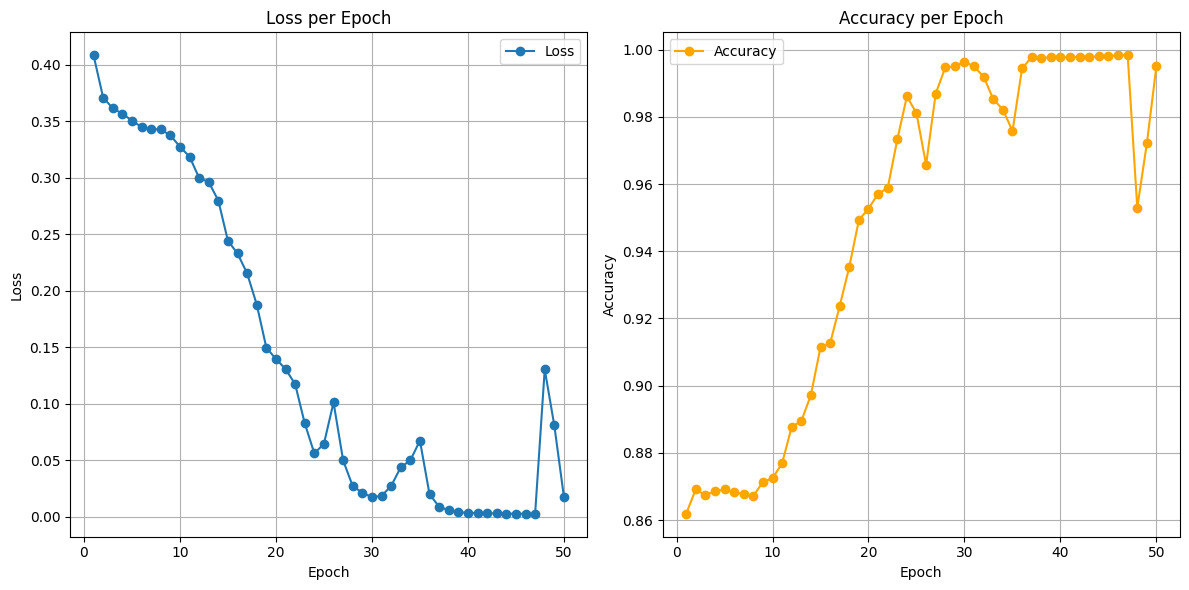

In [40]:
import matplotlib.pyplot as plt

# Plot Loss and Accuracy
plt.figure(figsize=(12, 6))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), loss_per_epoch, marker='o', label='Loss')
plt.title('Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), accuracy_per_epoch, marker='o', color='orange', label='Accuracy')
plt.title('Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid()
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()